# Using Machine Learning Algorithms To Predict Amazon Review Score and Sentiment

Note: Appliances dataset used can be found at http://deepyeti.ucsd.edu/jianmo/amazon/index.html

In [0]:
%pip install nltk
%pip install mlflow
%pip install yellowbrick

Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-2dd69750-7e28-4941-835e-d5dde265f090/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158155 sha256=5a6380aa2d8959007c6619cfbe0b0dd54924c3b4d41fe86e0b5187e1bc0fffe6
  Stored in directory: /root/.cache/pip/wheels/9d/de/6d/ca8d461ec29e010b1267d7353d0b058819770f7680bb9360e4
  Created wheel for databricks-cli: filename=databricks_cli-0.16.2-py3-none-any.whl size=106811 sha256=92c2d7503d6ffdd00303d7f2b57fc2a54dd9cbdcf85508ae66ca27e6a7ca708d
  Stored in directory: /root/.cache/pip/wheels/41/66/9f/fd5eb13d3397db11750e995d82055dca2528a2da030e144b2d
Successfully built alembic databricks-cli
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 1.1.1
    Not uninstalling markupsafe at /databricks/pyth

## 1. Data Preprocessing

In [0]:
# "dbfs:/FileStore/shared_uploads/braden.thompson1@ucalgary.ca/Appliances_5-1.json"
df = spark.read.format("json").load("dbfs:/FileStore/tables/Appliances_json.gz")
## Reduce data for development purposes 
#df = df.sample(0.005)

In [0]:
cols_to_drop = ('asin', 'image', 'reviewTime', 'reviewerID', 'reviewerName', 'style', 'summary', 'unixReviewTime', 'verified', 'vote')
df = df.drop(*cols_to_drop)
df = df.dropna()
df.show(10)

+-------+--------------------+
|overall|          reviewText|
+-------+--------------------+
|    5.0|I like business b...|
|    5.0|This is a nice so...|
|    5.0|Exactly what I wa...|
|    5.0|      Very satisfied|
|    5.0|Had a hard time f...|
|    4.0|It fits and works...|
|    4.0|My humidifier is ...|
|    4.0|They are what I n...|
|    4.0|Happy to find it ...|
|    1.0|The BestAir repla...|
+-------+--------------------+
only showing top 10 rows



### 1.1 Convert Rating to Sentiment
Ratings greater than or equal to 4 are given a score of 1 which represents a positive sentiment.
Ratings less than or 4 are given a score of 0 which represents a negetive sentiment.

In [0]:
from pyspark.sql.types import *

def convert_rating_to_sentiment(rating):
    # Rating >= 4 is positive. Rating < 4 is negative.
    if rating >= 4:
        return 1
    return 0

rating_convert = udf(lambda x: convert_rating_to_sentiment(x))
label_df = df.select('overall', 'reviewText', rating_convert('overall'))
label_df = label_df.withColumnRenamed('<lambda>(overall)', 'sentiment')
label_df.show(10)

+-------+--------------------+---------+
|overall|          reviewText|sentiment|
+-------+--------------------+---------+
|    5.0|I like business b...|        1|
|    5.0|This is a nice so...|        1|
|    5.0|Exactly what I wa...|        1|
|    5.0|      Very satisfied|        1|
|    5.0|Had a hard time f...|        1|
|    4.0|It fits and works...|        1|
|    4.0|My humidifier is ...|        1|
|    4.0|They are what I n...|        1|
|    4.0|Happy to find it ...|        1|
|    1.0|The BestAir repla...|        0|
+-------+--------------------+---------+
only showing top 10 rows



### 1.2 Remove All Punctuation and Convert to Lowercase

In [0]:
from pyspark.sql.functions import lower, regexp_replace, trim
from pyspark.sql.functions import col

def clean_text(text):
    result = lower(text)
    return trim(regexp_replace(result,'\\p{Punct}',''))

clean_text_df = label_df.select(label_df.overall, clean_text(label_df.reviewText).alias('cleaned_text'), label_df.sentiment)
clean_text_df.show(10)

+-------+--------------------+---------+
|overall|        cleaned_text|sentiment|
+-------+--------------------+---------+
|    5.0|i like business b...|        1|
|    5.0|this is a nice so...|        1|
|    5.0|exactly what i wa...|        1|
|    5.0|      very satisfied|        1|
|    5.0|had a hard time f...|        1|
|    4.0|it fits and works...|        1|
|    4.0|my humidifier is ...|        1|
|    4.0|they are what i n...|        1|
|    4.0|happy to find it ...|        1|
|    1.0|the bestair repla...|        0|
+-------+--------------------+---------+
only showing top 10 rows



### 1.3 Vectorize Text

In [0]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='cleaned_text', outputCol='vectorized_text')
vectorized_df = tokenizer.transform(clean_text_df).select('overall', 'vectorized_text', 'sentiment')


vectorized_df.show(10)

+-------+--------------------+---------+
|overall|     vectorized_text|sentiment|
+-------+--------------------+---------+
|    5.0|[i, like, busines...|        1|
|    5.0|[this, is, a, nic...|        1|
|    5.0|[exactly, what, i...|        1|
|    5.0|   [very, satisfied]|        1|
|    5.0|[had, a, hard, ti...|        1|
|    4.0|[it, fits, and, w...|        1|
|    4.0|[my, humidifier, ...|        1|
|    4.0|[they, are, what,...|        1|
|    4.0|[happy, to, find,...|        1|
|    1.0|[the, bestair, re...|        0|
+-------+--------------------+---------+
only showing top 10 rows



### 1.4 Remove Stop Words

In [0]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol='vectorized_text', outputCol='vectorized_text_no_stop_words')
vectorized_no_stop_words_df = remover.transform(vectorized_df).select('overall', 'vectorized_text_no_stop_words', 'sentiment')

vectorized_no_stop_words_df.show(10)

+-------+-----------------------------+---------+
|overall|vectorized_text_no_stop_words|sentiment|
+-------+-----------------------------+---------+
|    5.0|         [like, business, ...|        1|
|    5.0|         [nice, solution, ...|        1|
|    5.0|           [exactly, looking]|        1|
|    5.0|                  [satisfied]|        1|
|    5.0|         [hard, time, find...|        1|
|    4.0|         [fits, works, wel...|        1|
|    4.0|         [humidifier, olde...|        1|
|    4.0|         [needed, find, st...|        1|
|    4.0|         [happy, find, ama...|        1|
|    1.0|         [bestair, replace...|        0|
+-------+-----------------------------+---------+
only showing top 10 rows



### 1.5 Stem Text

In [0]:
from nltk.stem.porter import *

stemmer = PorterStemmer()
def stem(words):
    result = []
    for word in words:
        stemmed_word = stemmer.stem(word)
        result.append(stemmed_word)
    return result

stemmer_udf = udf(lambda x: stem(x), ArrayType(StringType()))

stemmed_df = (vectorized_no_stop_words_df.withColumn('stemmed_text',
                                                     stemmer_udf('vectorized_text_no_stop_words')).select('overall',
                                                     'stemmed_text', 'sentiment'))
stemmed_df.show(10)

+-------+--------------------+---------+
|overall|        stemmed_text|sentiment|
+-------+--------------------+---------+
|    5.0|[like, busi, book...|        1|
|    5.0|[nice, solut, rea...|        1|
|    5.0|     [exactli, look]|        1|
|    5.0|           [satisfi]|        1|
|    5.0|[hard, time, find...|        1|
|    4.0|[fit, work, well,...|        1|
|    4.0|[humidifi, older,...|        1|
|    4.0|[need, find, stor...|        1|
|    4.0|[happi, find, ama...|        1|
|    1.0|[bestair, replac,...|        0|
+-------+--------------------+---------+
only showing top 10 rows



### 1.6 Create IDF Model

In [0]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

cv = CountVectorizer(inputCol='stemmed_text', outputCol='count_vectorized')
cv_model = cv.fit(stemmed_df)
cv_transformed_df = cv_model.transform(stemmed_df)

idf = IDF()
idf.setInputCol('count_vectorized')
idf.setOutputCol('idf')
tfidf_model = idf.fit(cv_transformed_df)
tfidf_df = tfidf_model.transform(cv_transformed_df)
tfidf_df = tfidf_df.withColumn("sentiment",col("sentiment").cast("int"))
tfidf_df.show(10)

+-------+--------------------+---------+--------------------+--------------------+
|overall|        stemmed_text|sentiment|    count_vectorized|                 idf|
+-------+--------------------+---------+--------------------+--------------------+
|    5.0|[like, busi, book...|        1|(5107,[0,2,3,11,1...|(5107,[0,2,3,11,1...|
|    5.0|[nice, solut, rea...|        1|(5107,[1,8,10,16,...|(5107,[1,8,10,16,...|
|    5.0|     [exactli, look]|        1|(5107,[22,65],[1....|(5107,[22,65],[2....|
|    5.0|           [satisfi]|        1|  (5107,[424],[1.0])|(5107,[424],[4.67...|
|    5.0|[hard, time, find...|        1|(5107,[0,5,12,13,...|(5107,[0,5,12,13,...|
|    4.0|[fit, work, well,...|        1|(5107,[1,4,19,31,...|(5107,[1,4,19,31,...|
|    4.0|[humidifi, older,...|        1|(5107,[0,4,5,6,12...|(5107,[0,4,5,6,12...|
|    4.0|[need, find, stor...|        1|(5107,[15,84,96,1...|(5107,[15,84,96,1...|
|    4.0|[happi, find, ama...|        1|(5107,[5,6,12,23,...|(5107,[5,6,12,23,...|
|   

## 2. Sentiment Analysis & Prediction

### 2.1 Split Data Into Train and Test

In [0]:
(train, test) = tfidf_df.select('idf', 'sentiment').withColumnRenamed("idf", "features").withColumnRenamed("sentiment", "label").randomSplit([0.80, 0.20], seed=69)
#train.show(10)

In [0]:
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from pyspark.mllib.regression import LabeledPoint

# Turn train and test data into labeled points
train_lb = train.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))
test_lb = test.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))

### 2.2 Prepare Evaluators

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

sa_accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="actual_sentiment", predictionCol="predicted_sentiment", metricName="accuracy")
sa_f1_evaluator = MulticlassClassificationEvaluator(labelCol="actual_sentiment", predictionCol="predicted_sentiment", metricName="f1")
sa_recall_evaluator = MulticlassClassificationEvaluator(labelCol="actual_sentiment", predictionCol="predicted_sentiment", metricName="weightedRecall")
sa_precision_evaluator = MulticlassClassificationEvaluator(labelCol="actual_sentiment", predictionCol="predicted_sentiment", metricName="weightedPrecision")

sa_AccuracyResults = {}
sa_F1Results = {}
sa_RecallResults = {}
sa_PrecisionResults = {}

### 2.3 Train and Test Models

#### 2.3.1 SVM With SGD

In [0]:
from pyspark.mllib.classification import SVMWithSGD

svm_with_sgd = SVMWithSGD.train(train_lb, 50, regParam=0.3)

svm_with_sgd_pred = test_lb.map(lambda x: (float(svm_with_sgd.predict(x.features)), x.label))
svm_with_sgd_pred_df = spark.createDataFrame(svm_with_sgd_pred, ['predicted_sentiment', 'actual_sentiment'])
#svm_with_sgd_pred_df.show(10)

In [0]:
sa_AccuracyResults['SVMWithSGD'] = sa_accuracy_evaluator.evaluate(svm_with_sgd_pred_df)
sa_F1Results['SVMWithSGD'] = sa_f1_evaluator.evaluate(svm_with_sgd_pred_df)
sa_RecallResults['SVMWithSGD'] = sa_recall_evaluator.evaluate(svm_with_sgd_pred_df)
sa_PrecisionResults['SVMWithSGD'] = sa_precision_evaluator.evaluate(svm_with_sgd_pred_df)

#### 2.3.2 Naive Bayes

In [0]:
from pyspark.mllib.classification import NaiveBayes

nb = NaiveBayes.train(train_lb)
nb_pred = test_lb.map(lambda x: (float(nb.predict(x.features)), x.label))
nb_pred_df = spark.createDataFrame(nb_pred, ['predicted_sentiment', 'actual_sentiment'])
#nb_pred_df.show(10)

In [0]:
sa_AccuracyResults['NaiveBayes'] = sa_accuracy_evaluator.evaluate(nb_pred_df)
sa_F1Results['NaiveBayes'] = sa_f1_evaluator.evaluate(nb_pred_df)
sa_RecallResults['NaiveBayes'] = sa_recall_evaluator.evaluate(nb_pred_df)
sa_PrecisionResults['NaiveBayes'] = sa_precision_evaluator.evaluate(nb_pred_df)

#### 2.3.3 Logistic Regression With LBFGS

In [0]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

lr_lbfgs = LogisticRegressionWithLBFGS.train(train_lb)
lr_lbfgs_pred = test_lb.map(lambda x: (float(lr_lbfgs.predict(x.features)), x.label))
lr_lbfgs_pred_df = spark.createDataFrame(lr_lbfgs_pred, ['predicted_sentiment', 'actual_sentiment'])
#lr_lbfgs_pred_df.show(10)

In [0]:
sa_AccuracyResults['LogisticRegressionWithLBFGS'] = sa_accuracy_evaluator.evaluate(lr_lbfgs_pred_df)
sa_F1Results['LogisticRegressionWithLBFGS'] = sa_f1_evaluator.evaluate(lr_lbfgs_pred_df)
sa_RecallResults['LogisticRegressionWithLBFGS'] = sa_recall_evaluator.evaluate(lr_lbfgs_pred_df)
sa_PrecisionResults['LogisticRegressionWithLBFGS'] = sa_precision_evaluator.evaluate(lr_lbfgs_pred_df)

#### 2.3.4 Logistic Regression With SGD

In [0]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

lr_sgd = LogisticRegressionWithSGD.train(train_lb)
lr_sgd_pred = test_lb.map(lambda x: (float(lr_sgd.predict(x.features)), x.label))
lr_sgd_pred_df = spark.createDataFrame(lr_sgd_pred, ['predicted_sentiment', 'actual_sentiment'])
#lr_sgd_pred_df.show(10)

In [0]:
sa_AccuracyResults['LogisticRegressionWithSGD'] = sa_accuracy_evaluator.evaluate(lr_sgd_pred_df)
sa_F1Results['LogisticRegressionWithSGD'] = sa_f1_evaluator.evaluate(lr_sgd_pred_df)
sa_RecallResults['LogisticRegressionWithSGD'] = sa_recall_evaluator.evaluate(lr_sgd_pred_df)
sa_PrecisionResults['LogisticRegressionWithSGD'] = sa_precision_evaluator.evaluate(lr_sgd_pred_df)

### 2.4 Display Sentiment Analysis Results

In [0]:
sa_AccuracyResultsDF = sc.parallelize([ (k, v) for k,v in sa_AccuracyResults.items()]).toDF().withColumnRenamed("_1", "Model").withColumnRenamed("_2", "Accuracy")
sa_F1ResultsDF = sc.parallelize([ (k, v) for k,v in sa_F1Results.items()]).toDF().withColumnRenamed("_1", "Model").withColumnRenamed("_2", "F1")
sa_RecallResultsDF = sc.parallelize([ (k, v) for k,v in sa_RecallResults.items()]).toDF().withColumnRenamed("_1", "Model").withColumnRenamed("_2", "Recall")
sa_PrecisionResultsDF = sc.parallelize([(k, v) for k,v in sa_PrecisionResults.items()]).toDF().withColumnRenamed("_1","Model").withColumnRenamed("_2", "Precision")

sa_AccuracyResultsDF.show(truncate=False)
sa_F1ResultsDF.show(truncate=False)
sa_RecallResultsDF.show(truncate=False)
sa_PrecisionResultsDF.show(truncate=False)

+---------------------------+------------------+
|Model                      |Accuracy          |
+---------------------------+------------------+
|SVMWithSGD                 |0.8558421851289834|
|NaiveBayes                 |0.8315629742033384|
|LogisticRegressionWithLBFGS|0.8300455235204856|
|LogisticRegressionWithSGD  |0.8694992412746586|
+---------------------------+------------------+

+---------------------------+------------------+
|Model                      |F1                |
+---------------------------+------------------+
|SVMWithSGD                 |0.8387071839083254|
|NaiveBayes                 |0.8386006942600719|
|LogisticRegressionWithLBFGS|0.8327904045274751|
|LogisticRegressionWithSGD  |0.8612564869430327|
+---------------------------+------------------+

+---------------------------+------------------+
|Model                      |Recall            |
+---------------------------+------------------+
|SVMWithSGD                 |0.8558421851289834|
|NaiveBayes       

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def drawMetricsResults(accuracy_df, f1_df, recall_df, precision_df, scale):
    resultsDF = combineMetricDataFrames(accuracy_df, f1_df, recall_df, precision_df)
    metricsBarChart(resultsDF, scale)
    
def combineMetricDataFrames(accuracy_df, f1_df, recall_df, precision_df):
    result = accuracy_df.join(f1_df, on="Model")
    result = result.join(recall_df, on="Model")
    result = result.join(precision_df, on="Model")
    
    return result

def metricsBarChart(resultsDF, scale):
    resultsDF = resultsDF.toPandas()
    ax = resultsDF.plot(x="Model", \
                   y=["Accuracy", "F1", "Recall", "Precision"], \
                   kind="bar")
    bottom, top = scale
    ax.set_ylim(bottom, top)

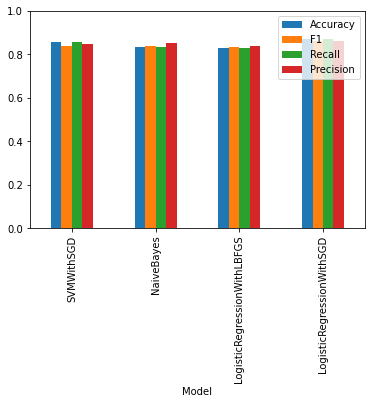

In [0]:
drawMetricsResults(sa_AccuracyResultsDF, \
                   sa_F1ResultsDF, \
                   sa_RecallResultsDF, \
                   sa_PrecisionResultsDF, \
                   (0, 1))

## 3. Star Rating Analysis & Prediction

Reference: https://docs.databricks.com/_static/notebooks/getting-started/get-started-with-mllib-dbr6.html

### 3.1 Split training and testing data

In [0]:
data = tfidf_df.select('idf', 'overall').withColumnRenamed("idf", "features").withColumnRenamed("overall", "label")
(train, test) = data.randomSplit([0.80, 0.20], seed=69)
#train.show(10)

### 3.2 Prepare Evaluators

In [0]:
## Set up performance evaluators for accuracy, f1, recall and precision
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

AccuracyEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
F1Evaluator = MulticlassClassificationEvaluator(metricName="f1")
RecallEvaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")
PrecisionEvaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")

AccuracyResults = {}
F1Results = {}
RecallResults = {}
PrecisionResults = {}

In [0]:
## Set up classifiers and parameters for tuning
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC, NaiveBayes

lr = LogisticRegression(featuresCol="features", labelCol="label", regParam=1.0)
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)
nb = NaiveBayes(featuresCol="features", labelCol="label", smoothing=1.0, modelType="multinomial")

lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
             .build())

rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(rf.maxBins, [10, 20, 40, 80, 100])
               .addGrid(rf.numTrees, [5, 20, 50, 100])
             .build())

nbparamGrid = (ParamGridBuilder()
             .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
             .build())

In [0]:
## Set up cross-validation for hyper-paramter tuning for each model

lrcv = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=lrparamGrid,
                           evaluator=AccuracyEvaluator,
                           trainRatio=0.8)
dtcv = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=dtparamGrid,
                           evaluator=AccuracyEvaluator,
                           trainRatio=0.8)
rfcv = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=rfparamGrid,
                           evaluator=AccuracyEvaluator,
                           trainRatio=0.8)
nbcv = TrainValidationSplit(estimator=nb,
                           estimatorParamMaps=nbparamGrid,
                           evaluator=AccuracyEvaluator,
                           trainRatio=0.8)

### 3.3 Train and Test Models

#### 3.3.1 Logistic Regression

In [0]:
## Fit and transform LR model
from sklearn import metrics

LrModel = lrcv.fit(train)
LrPredDF = LrModel.transform(test)

## Evaluate model
AccuracyResults['Logistic Regression'] = AccuracyEvaluator.evaluate(LrPredDF)
F1Results['Logistic Regression'] = F1Evaluator.evaluate(LrPredDF)
RecallResults['Logistic Regression'] = RecallEvaluator.evaluate(LrPredDF)
PrecisionResults['Logistic Regression'] = PrecisionEvaluator.evaluate(LrPredDF)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.


#### 3.3.2 Decision Tree

In [0]:
## Fit and transform DT model
DtModel = dtcv.fit(train)
DtPredDF = DtModel.transform(test)

## Evaluate model
AccuracyResults['Decision Tree'] = AccuracyEvaluator.evaluate(DtPredDF)
F1Results['Decision Tree'] = F1Evaluator.evaluate(DtPredDF)
RecallResults['Decision Tree'] = RecallEvaluator.evaluate(DtPredDF)
PrecisionResults['Decision Tree'] = PrecisionEvaluator.evaluate(DtPredDF)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.


#### 3.3.3 Random Forest

In [0]:
## Fit and transform RF model
RfModel = rfcv.fit(train)
RfPredDF = RfModel.transform(test)

## Evaluate model
AccuracyResults['Random Forest'] = AccuracyEvaluator.evaluate(RfPredDF)
F1Results['Random Forest'] = F1Evaluator.evaluate(RfPredDF)
RecallResults['Random Forest'] = RecallEvaluator.evaluate(RfPredDF)
PrecisionResults['Random Forest'] = PrecisionEvaluator.evaluate(RfPredDF)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.


#### 3.3.4 Naive Bayes

In [0]:
## Fit and transform NB model
NbModel = nbcv.fit(train)
NbPredDF = NbModel.transform(test)

## Evaluate model
AccuracyResults['Naive Bayes'] = AccuracyEvaluator.evaluate(NbPredDF)
F1Results['Naive Bayes'] = F1Evaluator.evaluate(NbPredDF)
RecallResults['Naive Bayes'] = RecallEvaluator.evaluate(NbPredDF)
PrecisionResults['Naive Bayes'] = PrecisionEvaluator.evaluate(NbPredDF)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.


### 3.4 Display Results

In [0]:
## View model evaluation results results

#Convert Dictionary to Dataframe
AccuracyResultsDF = sc.parallelize([ (k, v) for k,v in AccuracyResults.items()]).toDF().withColumnRenamed("_1", "Model").withColumnRenamed("_2", "Accuracy")
F1ResultsDF = sc.parallelize([ (k, v) for k,v in F1Results.items()]).toDF().withColumnRenamed("_1", "Model").withColumnRenamed("_2", "F1")
RecallResultsDF = sc.parallelize([ (k, v) for k,v in RecallResults.items()]).toDF().withColumnRenamed("_1", "Model").withColumnRenamed("_2", "Recall")
PrecisionResultsDF = sc.parallelize([(k, v) for k,v in PrecisionResults.items()]).toDF().withColumnRenamed("_1","Model").withColumnRenamed("_2", "Precision")

AccuracyResultsDF.show(truncate=False)
F1ResultsDF.show(truncate=False)
RecallResultsDF.show(truncate=False)
PrecisionResultsDF.show(truncate=False)

+-------------------+------------------+
|Model              |Accuracy          |
+-------------------+------------------+
|Logistic Regression|0.6949924127465857|
|Decision Tree      |0.6874051593323217|
|Random Forest      |0.6843702579666161|
|Naive Bayes        |0.0834597875569044|
+-------------------+------------------+

+-------------------+--------------------+
|Model              |F1                  |
+-------------------+--------------------+
|Logistic Regression|0.6128957656129983  |
|Decision Tree      |0.5673171945845096  |
|Random Forest      |0.5608915747577448  |
|Naive Bayes        |0.039120002599086816|
+-------------------+--------------------+

+-------------------+-------------------+
|Model              |Recall             |
+-------------------+-------------------+
|Logistic Regression|0.6949924127465857 |
|Decision Tree      |0.6874051593323217 |
|Random Forest      |0.6843702579666161 |
|Naive Bayes        |0.08345978755690439|
+-------------------+-----------

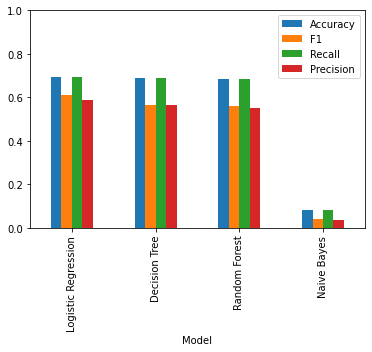

In [0]:
drawMetricsResults(AccuracyResultsDF, \
                   F1ResultsDF, \
                   RecallResultsDF, \
                   PrecisionResultsDF, \
                   (0, 1))